In [ ]:
!pip install yahoofinancials
!pip install pandas-ta
!pip install catboost
!pip install costcla


In [1]:
#IMPORT CLASSIFIERS
#IMPORT CLASSIFIERS
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from costcla.models import CostSensitiveRandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#IMPORT OTHERS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st
import pandas_ta as ta
import time
import warnings
import itertools
import hyperopt as hp

from collections import OrderedDict 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime
from yahoofinancials import YahooFinancials
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split,  cross_val_score, KFold, cross_val_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore", category=FutureWarning)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neural_network.multilayer_perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neural_network. Anything that cannot be imported from sklearn.neural_network is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 

In [2]:
# THIS ONE FOR CONFUSION MATRIX
def plot_confusion_matrix(cm,
                          target_names, 
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [30]:
class HELP():
    def __init__( self ):
        self.classifier_list = [ ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, SVC, MLPClassifier, KNeighborsClassifier,
                                CatBoostClassifier, LGBMClassifier,  XGBClassifier, StackingCVClassifier,
                                CostSensitiveRandomForestClassifier ]

        self.classifier_list_str = [ 'ExtraTreesClassifier','RandomForestClassifier', 'AdaBoostClassifier',
                                'GradientBoostingClassifier', 'SVC', 'MLPClassifier', 'KNeighborsClassifier',
                                'CatBoostClassifier', 'LGBMClassifier',  'XGBClassifier', 'StackingCVClassifier',
                                'CostSensitiveRandomForestClassifier' ]

        #self.class_list_spike = list()
        #self.class_list_crash = list()
        #self.class_key_spike = list()
        #self.class_key_crash = list()
        #self.last_x_days = last_x_days
        #self.cycle = cycle
        #self.counter = 0
        #self.counter_max = last_x_days // cycle -1 if last_x_days % cycle == 0 else last_x_days // cycle 
        #self.last_cycle = self.cycle if last_x_days % cycle == 0 else last_x_days % cycle
        #self.preprocess()
        #self.define_classes( return_days, multicollinearity )
        #self.DATE_TEST = self.DATE_ALL_DATA.iloc[ -last_x_days : ]
        #self.TEST_RETURNS = self.ALL_RETURNS[ -last_x_days : ]

    def preprocess( self ):
        print('\n PREPROCESSING \n')

        ticker_details = pd.read_excel('Ticker List.xlsx')
        ticker = ticker_details['Ticker'].to_list()
        names = ticker_details['Description'].to_list()

        #Extracting Data from Yahoo Finance and Adding them to Values table using date as key
        end_date= "2020-06-19"
        start_date = "2000-01-01"
        date_range = pd.bdate_range(start=start_date,end=end_date)
        values = pd.DataFrame({ 'Date': date_range})
        values['Date']= pd.to_datetime(values['Date'])

        #Extracting Data from Yahoo Finance and Adding them to Values table using date as key
        for i in ticker:
            raw_data = YahooFinancials(i)
            raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
            df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
            df.columns = ['Date1',i]
            df['Date1']= pd.to_datetime(df['Date1'])
            values = values.merge(df,how='left',left_on='Date',right_on='Date1')
            values = values.drop(labels='Date1',axis=1)
        self.VV = values

        #Renaming columns to represent instrument names rather than their ticker codes for ease of readability
        names.insert(0,'Date')
        values.columns = names
        values.tail()


        #Front filling the NaN values in the data set
        values = values.fillna(method="ffill",axis=0)
        values = values.fillna(method="bfill",axis=0)
        values.isna().sum()

        #Return
        values['SPX-RSI'] = ta.rsi( values['SPX'] )

        BBANDS = ta.bbands( values['SPX'] )
        keys = BBANDS.keys().to_list()

        Upper = BBANDS[ 'BBU_5' ]
        Lower = BBANDS[ 'BBL_5' ]

        Upper_perc = Upper / values['SPX']
        Lower_perc = Lower / values['SPX']

        values[ 'BBU-Distance' ] = Upper_perc
        values[ 'BBL-Distance' ] = Lower_perc
        values['MACD-Histogram'] = ta.macd( values[ 'SPX' ] )[ 'MACDH_12_26_9' ]
        # Co-ercing numeric type to all columns except Date
        cols=values.columns.drop('Date')
        values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=4)
        #print(values.tail())

        imp = ['Gold','USD Index', 'Oil', 'SPX','VIX', 'High Yield Fund' , 'Nikkei', 'Dax', '10Yr', '2Yr' , 'EEM' ,'XLE', 'XLF', 'XLI', 'AUDJPY']
        # Calculating Short term -Historical Returns
        change_days = [1,3,5,14,21]
        
        data = pd.DataFrame(data=values['Date'])
        for i in change_days:
            x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
            data=pd.concat(objs=(data,x),axis=1)
            x=[]



        # Calculating Long term Historical Returns
        change_days = [60,90,180,250]

        for i in change_days:
            x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
            data=pd.concat(objs=(data,x),axis=1)
            x=[]

        #Calculating Moving averages for SPX
        moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
        moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
        moving_avg['SPX/15SMA'] = (values['SPX']/(values['SPX'].rolling(window=15).mean()))-1
        moving_avg['SPX/30SMA'] = (values['SPX']/(values['SPX'].rolling(window=30).mean()))-1
        moving_avg['SPX/60SMA'] = (values['SPX']/(values['SPX'].rolling(window=60).mean()))-1
        moving_avg['SPX/90SMA'] = (values['SPX']/(values['SPX'].rolling(window=90).mean()))-1
        moving_avg['SPX/180SMA'] = (values['SPX']/(values['SPX'].rolling(window=180).mean()))-1
        moving_avg['SPX/90EMA'] = (values['SPX']/(values['SPX'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
        moving_avg['SPX/180EMA'] = (values['SPX']/(values['SPX'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
        moving_avg = moving_avg.dropna(axis=0)
        #Merging Moving Average values to the feature space
        data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')


        self.RAW_data = pd.merge(left=data,right=moving_avg,how='left',on='Date')

        self.RAW_y = pd.DataFrame(data=values['Date'])

        self.RAW_values = values

    def mult( self, data, threshold, TARGET = 'SPX' ):
        keys = data.keys().to_list()
        corr = data.corr()
        target_set = corr[ TARGET ]
        drop_list = list()
        
        #loop over features in corr matrix except SPX
        for i, key in enumerate(keys):
            if key != TARGET:
                
                print('EXAMINING {} \n '.format( key ) )
                print('DROP_LIST {} \n'.format( drop_list ) )
                #Get 'abs' corr values of current feature 
                values = corr[ key ]
                
                #we wont control corr between feature and [ SPX, features itself ] 
                #we will also skip dropped features in the next loop
                skip_list = [ TARGET, key ]

                #since skip_list will be updated for each feature
                #we save dropped features in drop_list to append it 
                #while exploring each feature
                if len( drop_list ) > 0:
                    #drop if drop_list is not empty
                    skip_list.extend( drop_list )

                print('SKIP LIST {} \n'.format( skip_list ) )
                #we will loop over 
                for k, ind in enumerate(keys):
                    #skip features in skip_list
                    if ind not in skip_list:

                        print(ind)
                        print(ind)
                        #if corr between 2 features exceeds threshold
                        if abs( values[ k ] ) > threshold:
                            print( values[ k ] )
                            #check which one is more corr to target
                            if corr[ TARGET ][ key ] > corr[ TARGET ][ ind ]:
                                #drop the other one
                                data = data.drop( ind, axis = 1 )
                                #append dropped feature's key to drop_list
                                drop_list.append( ind )
                                print('DROPPED {} \n '.format( ind ))
                            elif key not in drop_list:
                                #inverse of the 'statement' above
                                data = data.drop( key, axis = 1 )
                                drop_list.append( key )
                                print('DROPPED {} \n '.format( key ))
                                break

        return data, drop_list
                    
            
    def define_classes( self, return_days, multicollinearity ):
        print('\n DEFINING CLASSES \n')
        y = self.RAW_y
        values = self.RAW_values
        data = self.RAW_data
        
        y[ 'SPX-Target' ] = values[ "SPX" ].pct_change( periods = -return_days )
        y.isna().sum()

        # Removing NAs
        data = data[ data[ 'SPX-T-250' ].notna() ]
        y = y[ y[ 'SPX-Target' ].notna() ]

        #Adding Target Variables
        data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
        data.isna().sum()
        
        #Select Threshold p (left tail probability)
        p1 = 0.25
        p2 = 0.75
        #Get z-Value
        z1 = st.norm.ppf( p1 )
        z2 = st.norm.ppf( p2 )
       
        #Calculating Threshold (t) for each Y
        crash = round( (z1 * np.std( data[ "SPX-Target" ] ) ) + np.mean( data[ "SPX-Target" ] ), 5 )
        spike = round( (z2 * np.std( data[ "SPX-Target" ] ) ) + np.mean( data[ "SPX-Target" ] ), 5 )
        
        #Creating Labels
        data[ 'Y-Crash' ] = ( data[ 'SPX-Target' ] < crash ) * 1
        data[ 'Y-Spike' ] = ( data[ 'SPX-Target' ] > spike ) * 1

        #Save Dates
        self.DATE_ALL_DATA = data[ 'Date' ]
        last_values = values[ values[ 'Date' ] <= data[ 'Date' ].iloc[ -1 ] ]
        self.ALL_RETURNS = list()

        #Calculate cash returns
        RATES = data[ 'SPX-Target' ].to_list()
        CLOSE = last_values[ 'SPX' ].to_list()

        for i in range( len( data[ 'SPX-Target' ] ) ):
            self.ALL_RETURNS.append( RATES[ i ] * CLOSE[ i ] )

        #Prepare df for vif calculation
        no_target_data =  data.drop( [ 'SPX-Target', 'Date', 'Y-Crash', 'Y-Spike'  ], axis = 1 )
        #calculate vif
        self.vif_scores = self.variance_inflation_factors( no_target_data )
        #get feature names which vif > 10
        inds = (self.vif_scores > 10 ).index
        droplist = inds[ self.vif_scores > 10 ]

        if multicollinearity == True:
            data = data.drop( droplist, axis = 1 )

        #For now, data has Spike and Crash labels 
        self.data = data.drop( [ 'SPX-Target', 'Date'], axis = 1 )
        

    def variance_inflation_factors( self, exog_df ):

        exog_df = add_constant(exog_df)
        vifs = pd.Series(
            [1 / (1. - OLS(exog_df[col].values, 
                          exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
            for col in exog_df],
            index=exog_df.columns,
            name='VIF'
        )
        return vifs


    def select_classifier( self, classifier, key ):
        #for ELEM in self.classifier_list_str:
        #    if classifier == ELEM[ : len( classifier )  ]: 
        #        self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ) ]
        if key == 'crash':
            if classifier == 'EXT':
                self.class_list_crash.append( ExtraTreesClassifier( n_estimators = 300, random_state = 0 ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

            elif classifier == 'GB':
                self.class_list_crash.append( GradientBoostingClassifier( random_state = 0 ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )
                    
            elif classifier == 'CB':
                self.class_list_crash.append( CatBoostClassifier() )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

            elif classifier == 'STCK':
                est_list = list()
                for i in range( len( self.class_list_crash ) ):
                    est_list.append( ( self.class_key_crash[ i ], self.class_list_crash[ i ]  ) )
                self.class_list_crash.append( StackingClassifier(estimators = est_list,  cv = 5, final_estimator = CatBoostClassifier() ) )
                if classifier not in self.class_key_crash:
                    self.class_key_crash.append( classifier )

        elif key == 'spike':
            if classifier == 'EXT':
                self.class_list_spike.append( ExtraTreesClassifier( n_estimators = 300, random_state = 0 ) )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'GB':
                self.class_list_spike.append( GradientBoostingClassifier( random_state = 0 ) )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'CB':
                self.class_list_spike.append( CatBoostClassifier() )
                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

            elif classifier == 'STCK':
                est_list = list()
                for i in range( len(self.class_list_spike) ):
                    est_list.append( ( self.class_key_spike[ i ], self.class_list_spike[ i ]  ) )
                self.class_list_spike.append( StackingClassifier( estimators = est_list,  cv = 5, final_estimator = CatBoostClassifier() ) ) 

                if classifier not in self.class_key_spike:
                    self.class_key_spike.append( classifier )

    def backtest(self):
        list_of_cash_tt = list()
        self.make_pred( for_valid = False )
        classifiers = self.BT_RESULTS.keys().to_list()
        count = 0
        for CCC in classifiers:
            if CCC != 'Target':
                temp_cash = list()
                temp_cash.append( 0 )
                cc = 0

                preds = self.BT_RESULTS[ CCC ].to_list()

                assert len( preds ) ==  len( self.TEST_RETURNS )

                for i in range( len( preds ) ):
                    if preds[ i ] == 1:
                        cc += -self.TEST_RETURNS[ i ]
                    temp_cash.append( cc )

                if count == 0:
                    CASH = pd.DataFrame( { CCC: temp_cash  })
                    count += 1
                else:
                    CASH[ CCC ] = temp_cash
                    count += 1

        self.CASH = CASH
      


    def scores( self, typez ):
        if typez == 'crash':
            results = self.results_crash
        else:
            results = self.results_spike

        KEYS = results.keys().to_list()
        counter = 0
        for  key in KEYS:
            if key != 'Target':
                score_list = list()
                for metric in self.metrics:
                    score_list.append( metric( results[ 'Target' ], results[ key ] ) )

                if counter == 0:
                    scores = pd.DataFrame( { key: score_list  })
                    counter = counter + 1
                else:
                    scores[ key ] = score_list
                    counter = counter + 1

        if typez == 'crash':
            self.scores_crash = scores
        else:
            self.scores_spike = scores



    def redefine_classifiers( self ):
        self.class_list_spike = list()
        self.class_list_crash = list()
        for classifier in self.class_key_spike:
            self.select_classifier( classifier, 'spike' )
        for classifier in self.class_key_crash:
            self.select_classifier( classifier, 'crash' )


    def retrain( self ):

        for i in range( self.counter_max + 1 ):
            start_time = time.time()
            print( '\n TRAIN # {} \n'.format( i ) )
            self.update_data()
            self.redefine_classifiers()
            for classifier in self.class_list_spike:
                classifier.fit( self.X_train_spike, self.y_train_spike )

            for classifier in self.class_list_crash:
                classifier.fit( self.X_train_crash, self.y_train_crash )
            print('FINISHED {} \n '.format( i ) )
            print('Lasts : {} \n' .format(time.time() - start_time))

            self.make_pred( typez = 'crash' )
            self.make_pred( typez = 'spike' )
            self.counter += 1


    def smotetomek( self, X_train, y_train ):
        smt = SMOTETomek( random_state = 21 )
        return smt.fit_sample( X_train, y_train )


    def update_data( self ):

        #Update train-test split after every cycle time
        #if it is last cycle, use remaining days as test data
        if self.counter_max == self.counter:
            TEST_data = self.data.iloc[ -self.last_x_days + self.counter * self.cycle : ]
            TRAIN_data = self.data.iloc[ : -self.last_x_days + self.counter * self.cycle ]
        else:
            TEST_data = self.data.iloc[ -self.last_x_days + self.counter * self.cycle : -self.last_x_days + self.counter * self.cycle + self.cycle ]
            TRAIN_data = self.data.iloc[ : -self.last_x_days + self.counter * self.cycle ]


        #Create Training set and crash-spike labels
        X_train = TRAIN_data.drop( ['Y-Crash', 'Y-Spike'], axis = 1 )
        y_train_crash = TRAIN_data[ 'Y-Crash' ]
        y_train_spike = TRAIN_data[ 'Y-Spike' ]

        #Create test sets
        self.X_test = TEST_data.drop( [ 'Y-Spike', 'Y-Crash' ], axis = 1 )
        self.y_test_crash = TEST_data[ 'Y-Crash' ]
        self.y_test_spike = TEST_data[ 'Y-Spike' ]

        #Scale data between 0-1
        mm = MinMaxScaler()
        mm = mm.fit( X_train )
        X_train = mm.transform( X_train )
        self.X_test = mm.transform( self.X_test )

        #Create samples with smotetomek to eliminate imbalance of positive instances
        self.X_train_crash, self.y_train_crash = self.smotetomek( X_train, y_train_crash )
        self.X_train_spike, self.y_train_spike = self.smotetomek( X_train, y_train_spike )


    def make_pred( self, typez ):
        XXX = self.X_test
        if typez == 'crash':
            TARGET = self.y_test_crash
            classifiers = self.class_list_crash
            class_keys = self.class_key_crash
        else:
            TARGET = self.y_test_spike
            classifiers = self.class_list_spike
            class_keys = self.class_key_spike

        for i, classifier in enumerate( classifiers ):
            temp = classifier.predict( XXX )
            if i == 0:
                results = pd.DataFrame( { 'Target': TARGET, class_keys[ i ] : temp } )
            else:
                results[ class_keys[ i ] ] = temp
       

        if typez == 'crash':
            if self.counter == 0:
                self.results_crash = results
            else:
                self.results_crash = self.results_crash.append( results )

        else:
            if self.counter == 0:
                self.results_spike = results
            else:

                self.results_crash = self.results_crash.append( results )


    def confusion_matrix( self, classifier, key ):
        if key == 'crash':
            pred = self.results_crash[ classifier ]
            true = self.results_crash[ 'Target' ]
            return confusion_matrix( true, pred )
        elif key == 'spike':
            pred = self.results_spike[ classifier ]
            true = self.results_spike[ 'Target' ]
            return confusion_matrix( true, pred )


    def cash_test( self, preds ):
        cash = [ 0 for i in range( 13 ) ]
        CASHH = 0
        cash_gt = [ 0 for i in range( 13 ) ]
        CASHH_GT = 0
        test_ret_values = list( self.TEST_RETURNS )
        self.y_test = list(self.y_test)
        for i in range( len( preds ) ):
            CASHH = CASHH + test_ret_values[ i ] * preds[ i ]
            cash.append( CASHH )
            CASHH_GT = CASHH_GT + test_ret_values[ i ] * self.y_test[ i ]
            cash_gt.append( CASHH_GT )
        return cash, cash_gt


    def confusion_matrix( self ):
        pred = self.optimizer( self.X_test )
        true = self.y_test
        cm = np.array(confusion_matrix( true, pred ))
        plot_confusion_matrix( cm = cm, target_names = [ 'nothing', 'spike' ] )



In [31]:
class Tuner( HELP ):
    def __init__( self, multicollinearity = False, typez = 'spike' ):
        super().__init__()

        self.metrics = [ f1_score, precision_score, roc_auc_score ]
        self.metircs_key = [ 'f1', 'precision', 'roc_auc']
        self.classifier_list = [ ExtraTreesClassifier,RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, SVC, MLPClassifier, KNeighborsClassifier,
                                CatBoostClassifier, LGBMClassifier,  XGBClassifier, StackingCVClassifier,
                                CostSensitiveRandomForestClassifier ]

        self.classifier_list_str = [ 'ExtraTreesClassifier','RandomForestClassifier', 'AdaBoostClassifier',
                                'GradientBoostingClassifier', 'SVC', 'MLPClassifier', 'KNeighborsClassifier',
                                'CatBoostClassifier', 'LGBMClassifier',  'XGBClassifier', 'StackingCVClassifier',
                                'CostSensitiveRandomForestClassifier' ]
        self.typez = typez

    def choose_classifier( self, classifier, backtest = False ):
        self.class_key = classifier
        for ELEM in self.classifier_list_str:
            if classifier == ELEM[ : len( classifier )  ]: 
                if backtest:
                    self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]( **self.best_params )
                else:
                    self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]()


    def classifier_to_tune( self, classifier, backtest = False ):
        self.class_key = classifier
        for ELEM in self.classifier_list_str:
            if classifier == ELEM[ : len( classifier )  ]: 
                self.classifier = self.classifier_list[ self.classifier_list_str.index( ELEM ) ]


    def scale( self, X_train, X_test, scale_type = 'minmax' ):
        if scale_type == 'minmax':
            scaler = MinMaxScaler()
        elif scale_type == 'robust':
            scaler = RobustScaler()
        elif scale_type == 'standard':
            scaler = StandardScaler()
        elif scale_type == 'maxabs':
            scaler = MaxAbsScaler()

        scaler = scaler.fit( X_train )
        X_train = scaler.transform( X_train )
        X_test = scaler.transform( X_test )
        
        return X_train, X_test


    def prepare_data( self, smotetomek = True, b_test = False, test_percent = 0.3 ):
        shuffle = True
        data = self.data
            
        X = data.drop( ['Y-Crash', 'Y-Spike'], axis = 1 )

        if self.typez == 'crash':
            y = data[ 'Y-Crash' ]
        else:
            y = data[ 'Y-Spike' ]

        stratify = y

        if b_test:
            shuffle = False
            stratify = None
        
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = test_percent, random_state = 42, shuffle = shuffle, stratify = stratify )

        if smotetomek:
            X_train, y_train = self.smotetomek( X_train, y_train )

        X_train, X_test = self.scale( X_train, X_test )
        
        return X_train, X_test, y_train, y_test


    def process_data(self, return_days = 14, multicollinearity = False,
                     smotetomek = True, b_test = False, test_percent = 0.2 ):
      
        self.preprocess()
        self.define_classes( return_days, multicollinearity )
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data( smotetomek = smotetomek,
                                                                                  b_test = b_test,
                                                                                  test_percent = test_percent)
        self.TEST_RETURNS = self.ALL_RETURNS[ -len( self.y_test ) : ]
        self.TEST_DATES = self.DATE_ALL_DATA[ -len( self.y_test ) : ]


    def print_class_options( self ):
        for elem in self.classifier_list_str:
            print('{} \n'.format( elem ) )


    def train_tuned( self ):
        self.process_data( b_test = True, test_percent = 0.1 )
        self.classifier.fit( self.X_train, self.y_train )
        preds = self.classifier.predict( self.X_test )
        cash, cash_gt = self.cash_test( preds )
        return cash, cash_gt


In [32]:
class HPOpt(Tuner):

    def __init__(self, rosemary ):
        self.X_train = rosemary.X_train
        self.X_test  = rosemary.X_test
        self.y_train = rosemary.y_train
        self.y_test  = rosemary.y_test
        self.classifier = rosemary.classifier

    def process(self, fn_name, space, trials, algo, max_evals):
        
        fn = getattr(self, fn_name)
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)

        return result, trials


    def objective( self, args ):
        clf = self.classifier( **args )
        clf.fit( self.X_train, self.y_train )
        pred = clf.predict( self.X_test )
        score = f1_score( self.y_test, pred )
        return {'loss': -score, 'status': STATUS_OK}
        

In [44]:
rosemary = Tuner()
rosemary.process_data()


 PREPROCESSING 


 DEFINING CLASSES 



In [45]:
rosemary.classifier_to_tune( 'Cat' )

In [46]:

#We define list of values if we'll use hp.choice
#Because results just tell us the order of the optimal value
iter_list = range(100, 1000)
depth_list = range(4, 12)
policy_list = [ 'SymmetricTree', 'Depthwise', 'Lossguide' ]
border_list = range( 1, 200 )

SPACE = OrderedDict([('iterations', hp.choice('iterations', iter_list )  ),
                    ('learning_rate', hp.uniform('learning_rate', 0.001, 1 ) ),
                    ('depth', hp.choice('depth', depth_list ) ),
                    ('border_count', hp.choice('border_count', border_list ) ),
                    ('grow_policy', hp.choice('grow_policy', policy_list ) ) ] )


In [ ]:
hhh = HPOpt( rosemary )
best_params, trials_obj = hhh.process( fn_name = 'objective', space = SPACE, trials = Trials(), algo = tpe.suggest, max_evals = 100 ) #max_evals will be increased


387:	learn: 0.0109032	total: 6.38s	remaining: 7.39s

388:	learn: 0.0108459	total: 6.4s	remaining: 7.37s

389:	learn: 0.0108072	total: 6.42s	remaining: 7.36s

390:	learn: 0.0107127	total: 6.44s	remaining: 7.34s

391:	learn: 0.0106471	total: 6.45s	remaining: 7.32s

392:	learn: 0.0105560	total: 6.47s	remaining: 7.31s

393:	learn: 0.0105038	total: 6.48s	remaining: 7.29s

394:	learn: 0.0104661	total: 6.5s	remaining: 7.27s

395:	learn: 0.0103997	total: 6.51s	remaining: 7.25s

396:	learn: 0.0103530	total: 6.53s	remaining: 7.24s

397:	learn: 0.0102826	total: 6.55s	remaining: 7.22s

398:	learn: 0.0102270	total: 6.56s	remaining: 7.2s

399:	learn: 0.0101740	total: 6.58s	remaining: 7.19s

400:	learn: 0.0101351	total: 6.59s	remaining: 7.17s

401:	learn: 0.0100797	total: 6.62s	remaining: 7.16s

402:	learn: 0.0099690	total: 6.63s	remaining: 7.14s

403:	learn: 0.0099290	total: 6.65s	remaining: 7.13s

404:	learn: 0.0098924	total: 6.66s	remaining: 7.11s

405:	learn: 0.0097865	total: 6.68s	remaining: 7.0

In [37]:
best_params

{'border_count': 113,
 'depth': 5,
 'grow_policy': 1,
 'iterations': 2,
 'learning_rate': 0.6346362946956222}

In [38]:
best_params[ 'grow_policy' ] = policy_list[ best_params[ 'grow_policy' ] ] #best_params[ 'grow_policy' ] holds order of opt value, we extract real val from list
best_params[ 'depth' ] = depth_list[ best_params[ 'depth' ] ] #same here
best_params[ 'border_count' ] = border_list[ best_params[ 'border_count' ] ] #same here
best_params[ 'iterations' ] = iter_list[ best_params[ 'iterations' ] ] #same here
print(best_params)

{'border_count': 114, 'depth': 9, 'grow_policy': 'Depthwise', 'iterations': 12, 'learning_rate': 0.6346362946956222}


In [39]:
rosemary.best_params = best_params

In [40]:
#Displays available classifiers
#rosemary.print_class_options()

#You can choose classifier by specifying first few letter
rosemary.choose_classifier( 'Cat', backtest = True )


In [41]:
cash, cash_best_possible = rosemary.train_tuned()


 PREPROCESSING 


 DEFINING CLASSES 

0:	learn: 0.4099345	total: 543ms	remaining: 5.97s
1:	learn: 0.2971299	total: 1.06s	remaining: 5.29s
2:	learn: 0.1989801	total: 1.67s	remaining: 5s
3:	learn: 0.1561008	total: 2.18s	remaining: 4.37s
4:	learn: 0.1226331	total: 2.7s	remaining: 3.78s
5:	learn: 0.1047981	total: 3.14s	remaining: 3.14s
6:	learn: 0.0905736	total: 3.7s	remaining: 2.64s
7:	learn: 0.0765475	total: 4.22s	remaining: 2.11s
8:	learn: 0.0602804	total: 4.77s	remaining: 1.59s
9:	learn: 0.0481744	total: 5.29s	remaining: 1.06s
10:	learn: 0.0430476	total: 5.72s	remaining: 520ms
11:	learn: 0.0363046	total: 6.26s	remaining: 0us


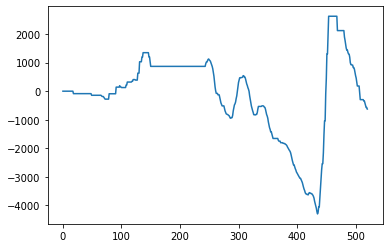

In [42]:
plt.plot(cash)

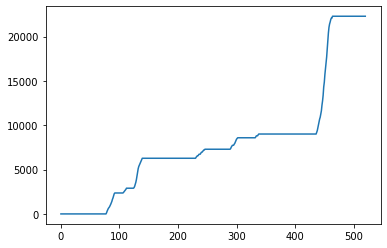

In [43]:
plt.plot(cash_best_possible)

In [ ]:
#plot confusion matrix
rosemary.confusion_matrix()

#if it does not work, try the code below. 
#You need to have test_pred first
#cm = np.array(confusion_matrix( rosemary.y_test, test_pred ))
#plot_confusion_matrix( cm = cm, target_names = [ 'nothing', 'spike' ] )

In [ ]:
#get back-test results
pred_returns, returns_with_grand_truth = rosemary.train_tuned()

In [ ]:
plt.plot( pred_returns )

In [61]:
global X
global Y

X = rosemary.X_train
Y = rosemary.y_train


In [60]:
sample( SPACE )

{'border_count': 112.08976256884324,
 'depth': 5,
 'grow_policy': 'Lossguide',
 'iterations': 996.7360741510896,
 'learning_rate': 0.018859030663855587}

In [73]:
print(best)

{'border_count': 121.62068796436915, 'depth': 6, 'feature_fraction': 1, 'iterations': 14.456372424780248, 'learning_rate': 0.5409026700346178}


In [ ]:
trials.trials.results[0]